## Task: Implementing a Simple Text Segmentation Algorithm

- Implement a simple algorithm for text segmentation.
- Use a test input of k paragraphs taken from different topics (e.g., Wikipedia pages).
- Can your system correctly identify the appropriate "cuts" in the text?



### Problem
The problem being addressed is the segmentation of a long text into coherent segments, where each segment captures a distinct topic or idea. The goal is to create segments that are internally cohesive in terms of their sentence similarities.

### Solution
The algorithm involves two main functions: `calculate_cohesion` and `text_tiling_segmentation`.

#### `calculate_cohesion`
This function computes the cohesion between two sentences using TF-IDF vectors and cosine similarity. It returns the mean cosine similarity as a measure of cohesion between sentences.

#### `text_tiling_segmentation`
1. The function reads an input text file and tokenizes it into sentences using NLTK.
2. It initializes the segmentation process by creating an initial segment containing the first sentence.
3. The algorithm iterates through a specified number of `max_iterations`.
4. For each segment:
   - It compares the current segment with subsequent sentences to calculate the cohesion value using the `calculate_cohesion` function.
   - If the cohesion value is above a specified `cohesion_threshold` or if it's very close to the threshold (within a small range), the sentence is added to the segment.
   - `cohesion_threshold` starts from a very small value then it gets the value of the last cohesion score, so when it drops it means the topic is changing so we create a new segment.
   - If the cohesion value is below the threshold, a new segment is created with the current sentence.
   - The process continues, updating and creating segments.
5. After the iteration, the algorithm calculate the coherence score of the last sentence of each segment with remaining sentences and the sentence is added to the segment with the highest coherence value.
6. The segments are consolidated and duplicate segments are removed.
7. The function returns a list of unique segments.


at the end of the code is present a plot where there are the cohesion scores and breakpoints.
### Result
Overall, the algorithm successfully segmented the dataset into meaningful topics, capturing distinct discussions. The resulting segments are coherent and aligned with the original content of the dataset.

In [2]:
import nltk
import numpy as np
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cohesion(sentences):
    """
    Calculate the cohesion between sentences based on TF-IDF vectors.

    Args:
        sentences (list): List of sentences to calculate cohesion for.

    Returns:
        float: Mean cosine similarity as a measure of cohesion.
    """
    # Create TF-IDF vectors for the sentences
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Calculate the cosine similarity between the TF-IDF vectors
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Calculate the mean cosine similarity as cohesion
    cohesion = similarity_matrix.mean()

    return cohesion

def text_tiling_segmentation(input_file_path, max_iterations, cohesion_threshold):
    """
    Perform text tiling segmentation on the input text.

    Args:
        input_file_path (str): Path to the input text file.
        max_iterations (int): Maximum number of segmentation iterations.
        cohesion_threshold (float): Cohesion threshold for segmenting.

    Returns:
        list: List of unique segments after text tiling segmentation.
    """
    # Read the input text file
    history_cohesion_threshold= {}
    history = []
    history.append(cohesion_threshold)
    break_points = []
    with open(input_file_path, "r", encoding="utf-8") as file:
        input_text = file.read()

    # Split the text into sentences
    sentences = nltk.sent_tokenize(input_text)
    num_sentences = len(sentences)
    
    if num_sentences == 0:
        return []

    segments = [sentences[0]]

    # Collect cohesion values during segmentation
    cohesion_values = []

    for iteration in range(max_iterations):
        updated_segments = []  # Store the updated segments for the current iteration
        
        for segment in segments:

            updated_segment = segment  # Store the updated segment text

            # Find the index of the segment in the list of segments
            segment_index = segments.index(segment)
            nTopic = 1
            for i in range(segment_index + 1, num_sentences):
                # Check if the sentence is already present in any segment
                if sentences[i] in ' '.join(updated_segments) or sentences[i] in ' '.join(segments):
                    continue

                # Calculate cohesion value between segment and the next sentence
                cohesion_value = calculate_cohesion([updated_segment, sentences[i]])

                # Collect the cohesion value for this step
                cohesion_values.append(cohesion_value)

                # Compare cohesion value with threshold
                if cohesion_value >= cohesion_threshold or abs(cohesion_value - cohesion_threshold) <= 0.009:
                    # Add the sentence to the segment if cohesion value is above threshold
                    updated_segment += " " + sentences[i]
                    cohesion_threshold = cohesion_value
                    history.append(cohesion_value)

                else:
                    # Create a new segment if cohesion value is below threshold
                    updated_segments.append(updated_segment)
                    updated_segment = sentences[i]
                    break_points.append(cohesion_value)
                    cohesion_threshold = 0.0
                    history_cohesion_threshold["Topic "+str(nTopic) ] = history
                    nTopic+=1
                    history = []
           
            history_cohesion_threshold["Topic "+str(nTopic) ] = history
            # Append the last updated segment
            updated_segments.append(updated_segment)

        segments = updated_segments.copy()

    # Compare the last sentence of each segment to remaining sentences
    last_sentences = [segment.split()[-1] for segment in segments]

    for i in range(num_sentences):
        if sentences[i] not in ' '.join(last_sentences):
            similarity_values = [calculate_cohesion([last_sentence, sentences[i]]) for last_sentence in last_sentences]
            most_similar_index = np.argmax(similarity_values)
            
            # Check if the sentence is already present in any segment
            if sentences[i] not in ' '.join(updated_segments) and sentences[i] not in ' '.join(segments):
                segments[most_similar_index] += " " + sentences[i]
                last_sentences[most_similar_index] = sentences[i]




    # Remove duplicate segments
    unique_segments = []
    seen_segments = set()
    for segment in segments:
        if segment not in seen_segments:
            unique_segments.append(segment)
            seen_segments.add(segment)

    return unique_segments , history_cohesion_threshold, break_points

# Parameters
input_file_path = "../lab4/corpusv2.txt"  # Adjust the input file path
max_iterations = 10  # Adjust as needed
cohesion_threshold = 0.0  # Adjust the cohesion threshold as needed

# Perform segmentation
segmented_segments, history_cohesion_threshold, break_points = text_tiling_segmentation(input_file_path, max_iterations, cohesion_threshold)

# Print the segments
for i, segment in enumerate(segmented_segments):
    print(f"Topic {i + 1}:\n{segment}\n{'-' * 40}")

    


Topic 1:
The Renaissance was a transformative cultural movement spanning the 14th to 17th centuries in Europe. It marked a revival of classical learning, igniting innovations in art, literature, architecture, and science. The period's philosophical and scientific advancements laid the foundation for modern society, reshaping artistic styles and inspiring new perspectives.
----------------------------------------
Topic 2:
The United Nations' 2030 Agenda for Sustainable Development outlines 17 SDGs. These goals encompass global challenges, including poverty, inequality, and climate change. Aimed at promoting responsible consumption, reducing carbon emissions, and ensuring equitable resource access, SDGs encourage collaborative efforts between governments, businesses, and individuals for a sustainable future.
----------------------------------------
Topic 3:
Artificial Intelligence (AI) simulates human intelligence using machines, encompassing machine learning, neural networks, natural la

<Figure size 3000x2500 with 0 Axes>

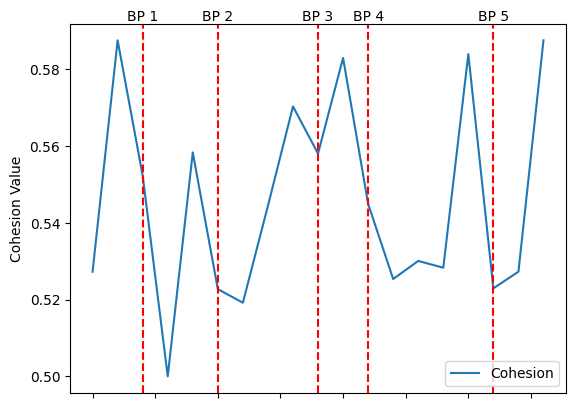

In [3]:

all_cohesion_values = []
i = 0
for top in history_cohesion_threshold.keys():
    all_cohesion_values.extend(history_cohesion_threshold[top])
    if i < len(break_points):
        all_cohesion_values.append(break_points[i])
        i += 1

# Set the figure size and adjust the padding between and around the subplots
plt.figure(figsize=(30, 25))
plt.subplots_adjust(bottom=0.2, wspace=0.7)

# Create the plot
fig, ax = plt.subplots()
ax.plot(range(len(all_cohesion_values)), all_cohesion_values, label='Cohesion')

# Add vertical lines at break points and label with topic names
for i, break_point in enumerate(break_points):
    x_position = all_cohesion_values.index(break_point)
    ax.axvline(x=x_position, color='red', linestyle='--')
    ax.text(x_position, ax.get_ylim()[1], f'BP {i+1}', ha='center', va='bottom')

# Remove x-axis tick labels
ax.set_xticklabels([])

# Add y-axis label and legend
ax.set_ylabel('Cohesion Value')
ax.legend()

# Show the plot
plt.show()
